# PJM Hourly Energy Consumption Forecast

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Load and Preprocess the Dataset

In [2]:
# load the dataset ,
# make 'Datetime' col as Index col,
# convert 'Datetime' col to datetime format

df = pd.read_excel('PJMW_MW_Hourly.xlsx',index_col='Datetime', parse_dates=True)

In [3]:
# Preview of first and Last 5 rows before sorting
df

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077
2002-12-31 02:00:00,4939
2002-12-31 03:00:00,4885
2002-12-31 04:00:00,4857
2002-12-31 05:00:00,4930
...,...
2018-01-01 20:00:00,8401
2018-01-01 21:00:00,8373
2018-01-01 22:00:00,8238


In [4]:
# Sort by datetime
df = df.sort_values('Datetime')

In [5]:
# Preview of first and Last 5 rows after sorting
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374
2002-04-01 02:00:00,4306
2002-04-01 03:00:00,4322
2002-04-01 04:00:00,4359
2002-04-01 05:00:00,4436
...,...
2018-08-02 20:00:00,6545
2018-08-02 21:00:00,6496
2018-08-02 22:00:00,6325


In [6]:
print("Start date:", df.index.min())
print("End date:", df.index.max())

# Count how many records fall in each year
print(df.index.year.value_counts().sort_index())

Start date: 2002-04-01 01:00:00
End date: 2018-08-03 00:00:00
Datetime
2002    6597
2003    8758
2004    8782
2005    8758
2006    8758
2007    8758
2008    8782
2009    8758
2010    8757
2011    8758
2012    8782
2013    8758
2014    8760
2015    8760
2016    8784
2017    8760
2018    5136
Name: count, dtype: int64


## Exploratory Data Analysis

### Data Overview

In [7]:
# Display dataframe structure and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   PJMW_MW  143206 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [8]:
# Statistical Analysis of the Mega watt energy
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


In [9]:
# check for null values
df.isnull().sum()

PJMW_MW    0
dtype: int64

### Feature Extraction

In [10]:
# Extract hour, day, weekday, month, and year from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

# Create a binary column indicating weekends (Saturday=5, Sunday=6)
df['is_weekend'] = df['weekday'] >= 5

# Create a binary column indicating US holidays
us_holidays = holidays.UnitedStates()
df['is_holiday'] = df.index.to_series().apply(lambda x: x.date() in us_holidays)

# Define seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
# Apply the season function to the 'month' column
df['season'] = df['month'].apply(get_season)

In [11]:
df

,PJMW_MW,hour,day,weekday,month,year,is_weekend,is_holiday,season
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374,1,1,0,4,2002,False,False,Spring
2002-04-01 02:00:00,4306,2,1,0,4,2002,False,False,Spring
2002-04-01 03:00:00,4322,3,1,0,4,2002,False,False,Spring
2002-04-01 04:00:00,4359,4,1,0,4,2002,False,False,Spring
2002-04-01 05:00:00,4436,5,1,0,4,2002,False,False,Spring
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545,20,2,3,8,2018,False,False,Summer
2018-08-02 21:00:00,6496,21,2,3,8,2018,False,False,Summer
2018-08-02 22:00:00,6325,22,2,3,8,2018,False,False,Summer


### Visualization

#### Trend Visualizations

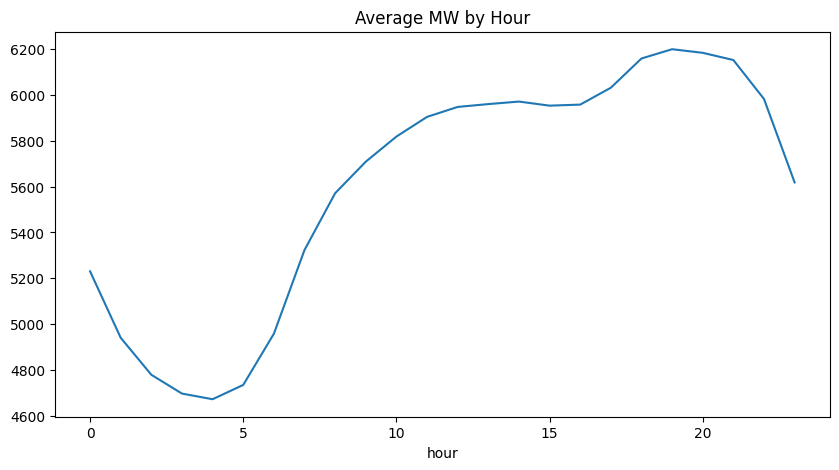

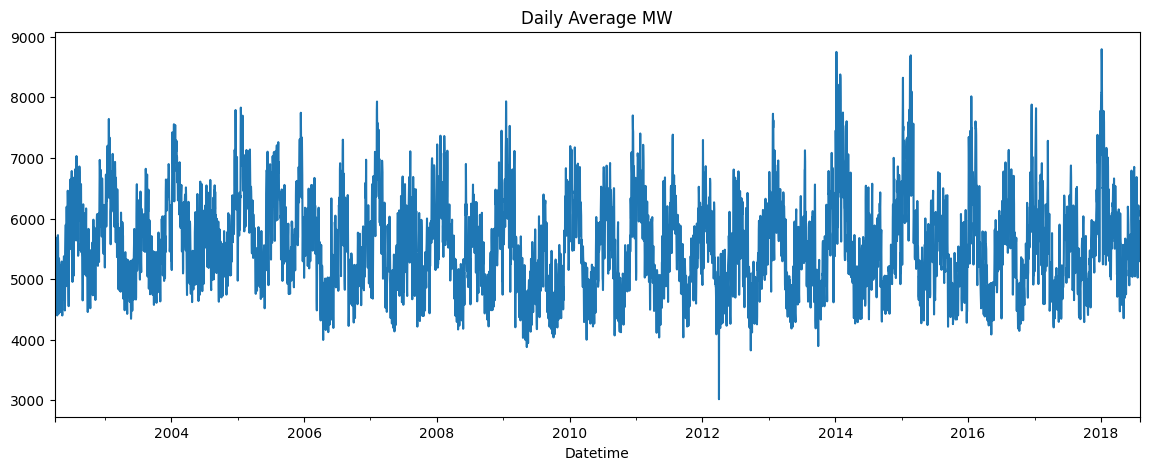

/var/folders/g9/0kv3n5gj1xs19b77mflndbfh0000gn/T/ipykernel_5126/1667557528.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M')['PJMW_MW'].mean().plot(title='Monthly Average MW', figsize=(14,5))


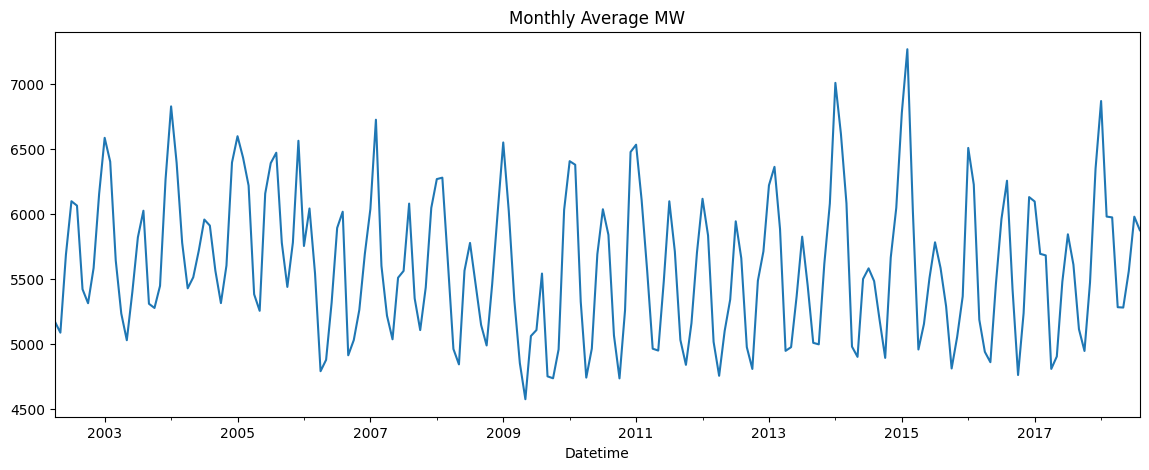

In [12]:
# average energy consumption by hour of the day
df.groupby('hour')['PJMW_MW'].mean().plot(title='Average MW by Hour', figsize=(10,5))
plt.show()

# daily average energy consumption
df.resample('D')['PJMW_MW'].mean().plot(title='Daily Average MW', figsize=(14,5))
plt.show()

# monthly average energy consumption
df.resample('M')['PJMW_MW'].mean().plot(title='Monthly Average MW', figsize=(14,5))
plt.show()

#### Weekday vs Weekend & Holiday Analysis

Text(0.5, 1.0, 'Holiday vs Non-Holiday Consumption')

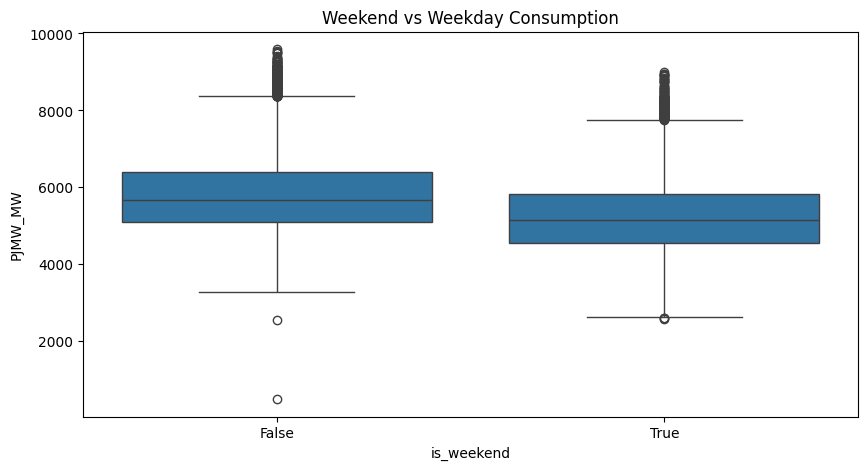

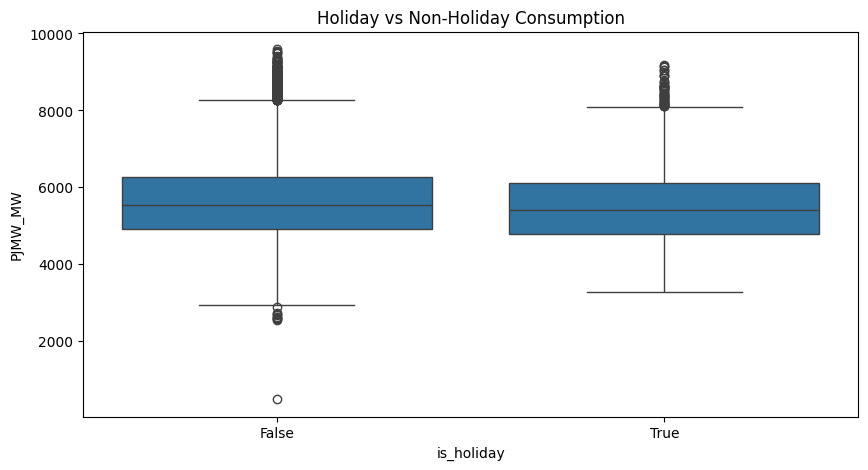

In [13]:
# Compare consumption on weekends vs weekdays
plt.figure(figsize=(10,5))
sns.boxplot(x='is_weekend', y='PJMW_MW', data=df).set_title('Weekend vs Weekday Consumption')

# Compare consumption on holidays vs non-holidays
plt.figure(figsize=(10,5))
sns.boxplot(x='is_holiday', y='PJMW_MW', data=df).set_title('Holiday vs Non-Holiday Consumption')

#### Seasonal Patterns

Text(0.5, 1.0, 'Average Hourly MW by Season')

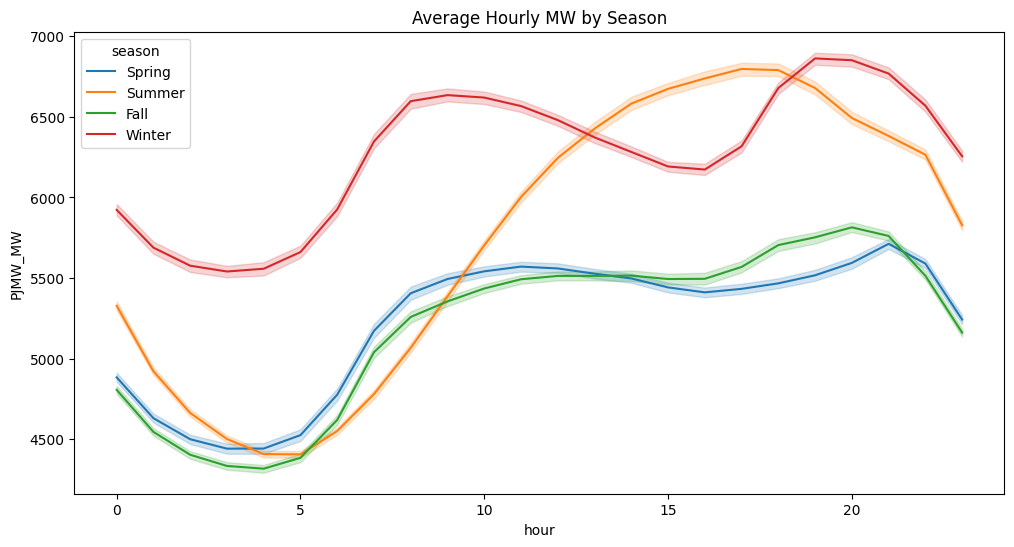

In [14]:
# Line plot showing average hourly consumption by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='hour', y='PJMW_MW', hue='season', estimator='mean')
plt.title('Average Hourly MW by Season')

#### Rolling Analysis (24hr)

<Axes: title={'center': 'Rolling 24hr Mean'}, xlabel='Datetime'>

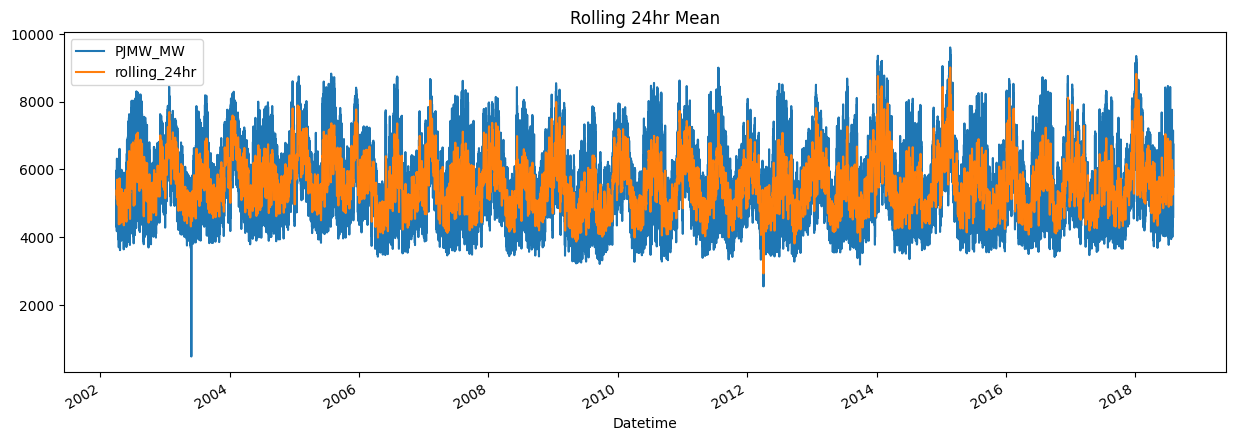

In [15]:
# Compute 24-hour rolling mean
df['rolling_24hr'] = df['PJMW_MW'].rolling(window=24).mean()

# Plot original and 24-hour rolling mean
df[['PJMW_MW', 'rolling_24hr']].plot(figsize=(15,5), title='Rolling 24hr Mean')

#### Seasonal Decomposition

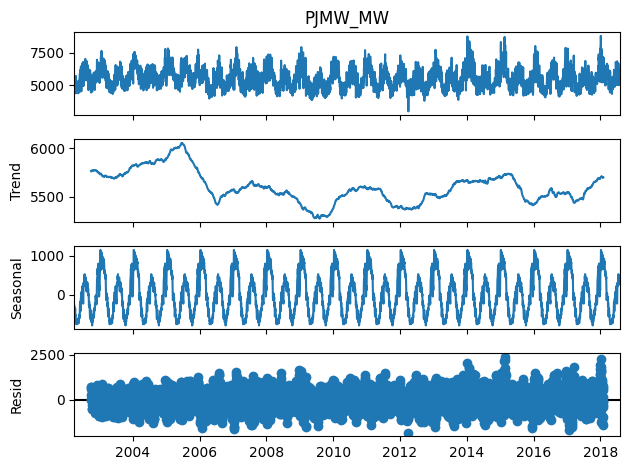

In [16]:
# Resample data to daily frequency and ensure consistent daily intervals
daily_df = df['PJMW_MW'].resample('D').mean()
daily_df = daily_df.asfreq('D')  # explicitly assign frequency

# Decompose the daily time series into trend, seasonality, and residuals
decomp = sm.tsa.seasonal_decompose(daily_df, model='additive', period=365)
decomp.plot();


#### Autocorrelation and Partial Autocorrelation

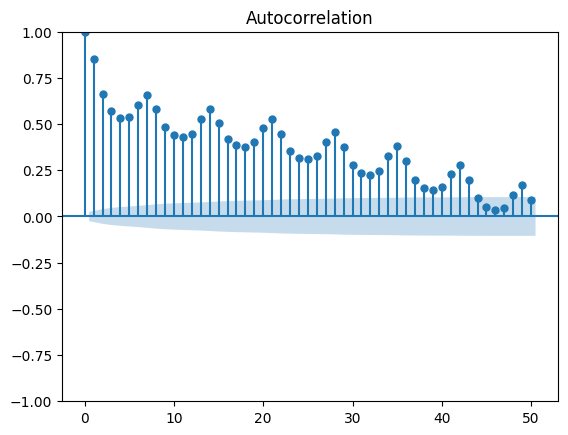

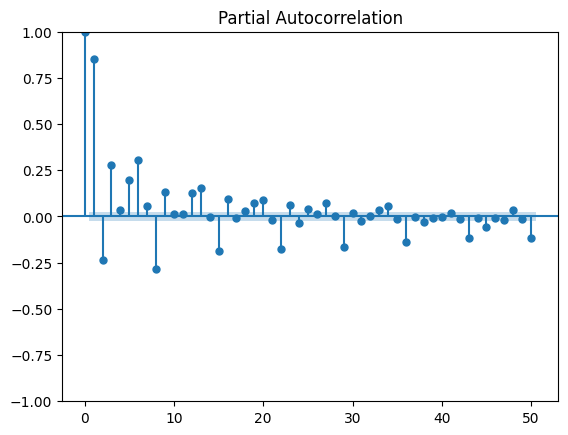

In [17]:
# Plot autocorrelation and partial autocorrelation to inspect lags
plot_acf(daily_df.dropna(), lags=50)
plot_pacf(daily_df.dropna(), lags=50);

#### Stationarity Check (ADF Test)

In [18]:
# Perform AD-Fuller test for stationarity

# H0 (Null Hypothesis): it is non-stationary
# H1 (Alternative Hypothesis): it is stationary

result = adfuller(daily_df.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value < 0.05, reject H0 and conclude the series is stationary

ADF Statistic: -7.264800831033437
p-value: 1.6456615780433146e-10


In [19]:
# Train-test split: last 30 days
train = df.loc[:'2018-07-03 23:00:00']['PJMW_MW']
test = df.loc['2018-07-04 00:00:00':]['PJMW_MW']

print(f"Train: {train.index.min()} to {train.index.max()}")
print(f"Test: {test.index.min()} to {test.index.max()}")

Train: 2002-04-01 01:00:00 to 2018-07-03 23:00:00
Test: 2018-07-04 00:00:00 to 2018-08-03 00:00:00


In [20]:
# Convert season column to numeric
df['season'] = df['season'].astype('category').cat.codes

# Feature and target selection
features = df[['hour', 'day', 'month', 'year', 'weekday','is_weekend','is_holiday','season']]
target = df['PJMW_MW']


In [21]:

# Train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [22]:
# Import models and metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    print(f"{name}:")
    print(f"  R² Score: {r2:.3f}")
    print(f"  MAE     : {mae:.2f}")
    print(f"  RMSE    : {rmse:.2f}\n")




Linear Regression:
  R² Score: 0.436
  MAE     : 584.16
  RMSE    : 734.97

Random Forest:
  R² Score: 0.947
  MAE     : 145.35
  RMSE    : 225.48

Gradient Boosting:
  R² Score: 0.706
  MAE     : 407.64
  RMSE    : 530.34

XGBoost:
  R² Score: 0.886
  MAE     : 247.88
  RMSE    : 329.81



In [23]:

# Save the best model
import joblib
joblib.dump(models['Random Forest'], 'random_forest_model.pkl')
print("model saved as 'random_forest_model.pkl'")


model saved as 'random_forest_model.pkl'
